<a href="https://colab.research.google.com/github/Alexandr-M-85/Neural-University/blob/main/%D0%9E%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B0_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%B0.%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_Sequence_to_sequence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Добро пожаловать на задание уровня Lite.
В данной задаче требуется создать 2 модели для перевода.
1. С английского на русский.
2. С русского на английский.

По итогу требуется подать выход первой модели во вторую модель и сравнить начальный текст и дважды переведенный.
Добиться максимальной точности.

In [ ]:
# Подключим модуль для загрузки файлов в colab
from google.colab import files

# Подключим модуль numpy для работы с массивами
import numpy as np

# Подгрузим модели кераса
from tensorflow.keras.models import Model, load_model

# Подключим нужные слои
from tensorflow.keras.layers import Dense, Embedding, LSTM, Input

# Поключим оптимайзеры
from tensorflow.keras.optimizers import RMSprop, Adadelta

# Подключим метод ограничения последовательности заданной длиной
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Подключим токенайзер
from tensorflow.keras.preprocessing.text import Tokenizer

# Подключим модуль для one hot кодировки
from tensorflow.keras import utils

# Подключим визуализацию графа модели
from tensorflow.keras.utils import plot_model

# Подключим модуль для работы с yaml - файлами
import yaml

In [ ]:
# Загрузим обучающие тексты
!wget  http://www.manythings.org/anki/rus-eng.zip

--2022-01-24 15:05:06--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14683939 (14M) [application/zip]
Saving to: ‘rus-eng.zip.3’

rus-eng.zip.3       100%[===================>]  14.00M  79.8MB/s    in 0.2s    

2022-01-24 15:05:06 (79.8 MB/s) - ‘rus-eng.zip.3’ saved [14683939/14683939]



In [ ]:
# Распакуем архив
!unzip -o rus-eng.zip 

Archive:  rus-eng.zip
  inflating: rus.txt                 
  inflating: _about.txt              


# Подготовка переводчика EN->RU

In [ ]:
# соберем все фразы

# Заготовим список для пар фраз
conversations = []

# Открываем файл словаря в режиме чтения
with open("rus.txt", 'r', encoding='utf-8') as f:
    # Читаем весь файл, режем на строки
    lines = f.read().split('\n')

# Цикл по строкам
for i,line in enumerate(lines):
    # для обучения возьмем 150000 строк
    if i>150000:
      break
    # Берем очередную строку, режем по символу табуляции
    try:
        input_text, target_text,_ = line.split("\t")
        # Заполняем список пар фраз
        conversations.append([input_text, target_text])
     # если не получается - идем за следущей строкой
    except:
        continue                                       

In [ ]:
def my_replacer(s):  

    ''' Функция для удаления пробелов перед знаками препинания
        Args: строка или список строк
        Returns: строка или список строк
    '''

    # Если получили строку
    if isinstance(s,str):
        # Убираем перед знаками препинания пробел и возвращаем
        return s.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?')

    # Если получили список
    if isinstance(s,list):
        # Заготовим пустой список
        ou=[]

        # Цикл по строкам из списка
        for l in s:
            # Убираем перед знаками препинания пробел и возвращаем
            ou.append(l.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?'))

        # Вернем список строк
        return ou 

In [ ]:
# Собираем вопросы и ответы в списки

# Переменные для списка входных и ответных фраз EN-RU переводчика
questions_en, answers_ru = [], []

# Цикл по всем парам фраз 
for con in conversations:
    # Если ответная фраза содержит более одно двух предложений
    if len(con) > 1 :
        # То первую в списке фразу отправляем в список входных фраз
        questions_en.append(my_replacer(con[0]))
        # А ответную составляем из последующих строк
        replies = my_replacer(con[1:])
        # Здесь соберем ответ
        ans = ' '.join(replies)
        # Добавим в список ответов
        answers_ru.append(ans)
    # Иначе идем на новой парой фраз
    else:
        continue                              
# Добавим в каждую ответную фразу теги  <START> и <END>
answers_ru = ['<START> ' + s + ' <END>' for s in answers_ru]


# Переменные для списка входных и ответных фраз RU_EN переводчика
questions_ru, answers_en = [], []

# Цикл по всем парам фраз 
for con in conversations:
    # Если ответная фраза содержит более одно двух предложений
    if len(con) > 1 :
        # То первую в списке фразу отправляем в список входных фраз
        answers_en.append(my_replacer(con[0]))
        # А ответную составляем из последующих строк
        replies = my_replacer(con[1:])
        # Здесь соберем ответ
        ans = ' '.join(replies)
        # Добавим в список ответов
        questions_ru.append(ans)
    # Иначе идем на новой парой фраз
    else:
        continue                              

# Добавим в каждую ответную фразу теги  <START> и <END>
answers_en = ['<START> ' + s + ' <END>' for s in answers_en]

# Выведем обновленные данные на экран
print(f'Фраза : {questions_en[5674]}')
print(f'Перевод : {answers_ru[5674]}')
print()
print(f'Фраза : {questions_ru[5674]}')
print(f'Перевод : {answers_en[5674]}')
print()
print(f'Количество фраз: {len(questions_ru)}')
print(f'Количество переводов: {len(answers_en)}')

Фраза : We're young.
Перевод : <START> Мы молоды. <END>

Фраза : Мы молоды.
Перевод : <START> We're young. <END>

Количество фраз: 150001
Количество переводов: 150001


In [ ]:
# собираем словарь индексов с помощью токенизатора
tokenizer = Tokenizer(oov_token='unknown')
# загружаем в токенизатор список фраз для сборки словаря частотности
tokenizer.fit_on_texts(questions_en + answers_ru)
# список с cодержимым словаря
vocabularyItems = list(tokenizer.word_index.items())
# размер словаря
vocabularySize = len(vocabularyItems)+1
# выведем информацию
print(f'Фрагмент словаря: {vocabularyItems[:100]}')
print(f'Размер словаря: {vocabularySize}')

Фрагмент словаря: [('unknown', 14314), ('start', 2), ('end', 3), ('я', 4), ('tom', 5), ('i', 6), ('you', 7), ('том', 8), ('не', 9), ('это', 10), ('a', 11), ('to', 12), ('is', 13), ('ты', 14), ('the', 15), ('it', 16), ('вы', 17), ('что', 18), ('do', 19), ('мне', 20), ('me', 21), ("i'm", 22), ('that', 23), ('в', 24), ('у', 25), ('мы', 26), ('was', 27), ('this', 28), ('we', 29), ('меня', 30), ('тома', 31), ("don't", 32), ('are', 33), ('have', 34), ('my', 35), ('your', 36), ('did', 37), ('он', 38), ('на', 39), ('can', 40), ('he', 41), ('go', 42), ('с', 43), ('what', 44), ('тому', 45), ('be', 46), ('like', 47), ("you're", 48), ('not', 49), ('in', 50), ('был', 51), ("it's", 52), ('know', 53), ('тебе', 54), ('очень', 55), ('want', 56), ('они', 57), ('тебя', 58), ('here', 59), ('как', 60), ('why', 61), ('for', 62), ("i'll", 63), ('on', 64), ('вас', 65), ('вам', 66), ('need', 67), ('they', 68), ('very', 69), ('of', 70), ('есть', 71), ('его', 72), ('кто', 73), ('how', 74), ('help', 75), ('us', 7

In [ ]:
def for_input(questions):
    """
    Функция преобразует вопросы в список индексов
    """
    # вопросы преобразуем в последовательность индексов
    tokenizedQuestions = tokenizer.texts_to_sequences(questions)
    # сохраняем количество слов в самом длинном вопросе
    maxLenQuestions = max([ len(x) for x in tokenizedQuestions])
    # Делаем последовательности одинаковой длины, заполняя нулями более короткие вопросы
    encoderForInput = pad_sequences(tokenizedQuestions, maxlen=maxLenQuestions, padding='post')
    return encoderForInput

In [ ]:
# преобразуем вопросы на EN
encoderForInput_EN_RU = for_input(questions_en)

# выведем информацию
print(f'Пример оригинальной фразы на вход: {questions_en[24591]}') 
print(f'Пример кодированной фразы на вход: {encoderForInput_EN_RU[24591]}') 
print(f'Размеры закодированного массива фраз на вход: {encoderForInput_EN_RU.shape}')

Пример оригинальной фразы на вход: Keep it in mind.
Пример кодированной фразы на вход: [337  16  50 770   0   0   0   0]
Размеры закодированного массива фраз на вход: (150001, 8)


In [ ]:
# преобразуем ответы на RU
decoderForInput_EN_RU = for_input(answers_ru)
# выведем информацию
print(f'Пример переведенной фразы на вход: {answers_ru[24591]}') 
print(f'Пример раскодированного ответа на вход: {decoderForInput_EN_RU[24591]}') 
print(f'Размеры раскодированного массива ответов на вход: {decoderForInput_EN_RU.shape}')

Пример переведенной фразы на вход: <START> Имейте это в виду. <END>
Пример раскодированного ответа на вход: [   2 8694   10   24 1128    3    0    0    0    0    0    0    0]
Размеры раскодированного массива ответов на вход: (150001, 13)


In [ ]:
def decoder_for_output(answers):
    """
    Функция для преобразования переведенного текста,
    который идет на обучение модели в последовательность индексов
    """
    # разбиваем текст ответов на последовательности индексов
    tokenizedAnswers = tokenizer.texts_to_sequences(answers)
    # сохраняем количество слов в самом длинном вопросе
    maxLenAnswers = max([ len(x) for x in tokenizedAnswers])

    # избавляемся от тега <START> в каждом ответе
    for i in range(len(tokenizedAnswers)):
        tokenizedAnswers[i] = tokenizedAnswers[i][1:]
    # Делаем последовательности одинаковой длины, заполняя нулями более короткие ответы
    paddedAnswers = pad_sequences(tokenizedAnswers, maxlen=maxLenAnswers , padding='post')

    # и сохраняем в виде массива numpy
    decoderForOutput = np.array(paddedAnswers)

    return decoderForOutput, maxLenAnswers

In [ ]:
decoderForOutput_EN_RU, maxLenAnswers_EN_RU = decoder_for_output(answers_ru)
# выведем информацию
print(f'Пример раскодированного ответа на вход: {decoderForInput_EN_RU[100]}')
print(f'Пример раскодированного ответа на выход: {decoderForOutput_EN_RU[100]}')
print(f'Размеры раскодированного массива ответов на выход: {decoderForOutput_EN_RU.shape}')

Пример раскодированного ответа на вход: [   2  696   43 2543    3    0    0    0    0    0    0    0    0]
Пример раскодированного ответа на выход: [ 696   43 2543    3    0    0    0    0    0    0    0    0    0]
Размеры раскодированного массива ответов на выход: (150001, 13)


### Парметры нейросети и моделирование обучения

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 200)    7081200     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, None, 200)    7081200     ['input_2[0][0]']                
                                                                                              

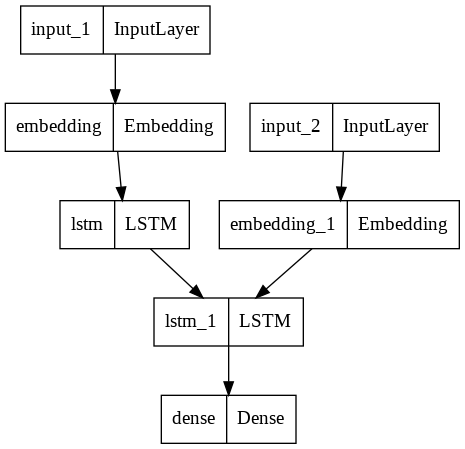

In [ ]:
# первый входной слой

# размеры на входе сетки (здесь будет encoderForInput)
encoderInputs = Input(shape=(None, ))
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True) (encoderInputs)

# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

# второй входной слой

# размеры на входе сетки (здесь будет decoderForInput)
decoderInputs = Input(shape=(None, ))

# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM(decoderEmbedding, initial_state=encoderStates)

# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense(decoderOutputs)

# собираем модель переводчика EN->RU
model_EN_RU = Model([encoderInputs, decoderInputs], output)
model_EN_RU.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy')

# выведем на экран информацию о построенной модели нейросети
print(model_EN_RU.summary())

# и построим график для визуализации слоев и связей между ними
utils.plot_model(model_EN_RU)

In [ ]:
# обучение модели
model_EN_RU.fit([encoderForInput_EN_RU[:149000], decoderForInput_EN_RU[:149000]], decoderForOutput_EN_RU[:149000], batch_size=256, epochs=50)

Epoch 1/50
583/583 [==============================] - 41s 55ms/step - loss: 1.8378
Epoch 2/50
583/583 [==============================] - 32s 55ms/step - loss: 1.3746
Epoch 3/50
583/583 [==============================] - 32s 55ms/step - loss: 1.1499
Epoch 4/50
583/583 [==============================] - 32s 55ms/step - loss: 0.9990
Epoch 5/50
583/583 [==============================] - 32s 55ms/step - loss: 0.8940
Epoch 6/50
583/583 [==============================] - 32s 55ms/step - loss: 0.8171
Epoch 7/50
583/583 [==============================] - 32s 55ms/step - loss: 0.7611
Epoch 8/50
583/583 [==============================] - 32s 55ms/step - loss: 0.7216
Epoch 9/50
583/583 [==============================] - 32s 55ms/step - loss: 0.6895
Epoch 10/50
583/583 [==============================] - 32s 55ms/step - loss: 0.6637
Epoch 11/50
583/583 [==============================] - 32s 55ms/step - loss: 0.6451
Epoch 12/50
583/583 [==============================] - 32s 55ms/step - loss: 0.6295
E

In [ ]:
# Создаем рабочую модель для вывода ответов на запросы пользователя

def makeInferenceModels():

    ''' Функция сборки сети для перевода фраз из уже обученных слов

        Args: -

        Returns: модели энкодера и декодера   
    '''    

    # Создадим модель кодера, на входе далее будут закодированные вопросы, на выходе состояния state_h, state_c
    encoderModel = Model(encoderInputs, encoderStates) 

    # Создадим модель декодера
    # обозначим размерность для входного слоя с состоянием state_h
    decoderStateInput_h = Input(shape=(200 ,))
    # обозначим размерность для входного слоя с состоянием state_c
    decoderStateInput_c = Input(shape=(200 ,))

    # Соберем оба inputs вместе и сохраним в decoderStatesInputs
    decoderStatesInputs = [decoderStateInput_h, decoderStateInput_c] 

    # Берём ответы, прошедшие через эмбединг, вместе с состояниями и подаём LSTM cлою
    decoderOutputs, state_h, state_c = decoderLSTM(decoderEmbedding, initial_state=decoderStatesInputs) 
    
    # LSTM даст нам новые состояния
    decoderStates = [state_h, state_c]            
    
    # И ответы, которые мы пропустим через полносвязный слой с софтмаксом
    decoderOutputs = decoderDense(decoderOutputs) 

    # Определим модель декодера, на входе далее будут раскодированные ответы (decoderForInputs) и состояния
    # на выходе предсказываемый ответ и новые состояния
    decoderModel = Model([decoderInputs] + decoderStatesInputs, [decoderOutputs] + decoderStates)

    # Вернем рабочие модели энкодера и декодера  
    return encoderModel , decoderModel

In [ ]:
encModel_EN_RU, decModel_EN_RU = makeInferenceModels()

# Подготовка переводчика RU->EN

In [ ]:
# преобразуем вопросы на RU
encoderForInput_RU_EN = for_input(questions_ru)

# выведем информацию
print(f'Пример оригинальной фразы на вход: {questions_ru[24591]}') 
print(f'Пример кодированной фразы на вход: {encoderForInput_RU_EN[24591]}') 
print(f'Размеры закодированного массива фраз на вход: {encoderForInput_RU_EN.shape}')

Пример оригинальной фразы на вход: Имейте это в виду.
Пример кодированной фразы на вход: [8694   10   24 1128    0    0    0    0    0    0    0]
Размеры закодированного массива фраз на вход: (150001, 11)


In [ ]:
# преобразуем ответы на EN
decoderForInput_RU_EN = for_input(answers_en)
# выведем информацию
print(f'Пример переведенной фразы на вход: {answers_en[24591]}') 
print(f'Пример раскодированного ответа на вход: {decoderForInput_RU_EN[24591]}') 
print(f'Размеры раскодированного массива ответов на вход: {decoderForInput_RU_EN.shape}')

Пример переведенной фразы на вход: <START> Keep it in mind. <END>
Пример раскодированного ответа на вход: [  2 337  16  50 770   3   0   0   0   0]
Размеры раскодированного массива ответов на вход: (150001, 10)


In [ ]:
decoderForOutput_RU_EN, maxLenAnswers_RU_EN = decoder_for_output(answers_en)
# выведем информацию
print(f'Пример раскодированного ответа на вход: {decoderForInput_RU_EN[100]}')
print(f'Пример раскодированного ответа на выход: {decoderForOutput_RU_EN[100]}')
print(f'Размеры раскодированного массива ответов на выход: {decoderForOutput_RU_EN.shape}')

Пример раскодированного ответа на вход: [    2 11658     3     0     0     0     0     0     0     0]
Пример раскодированного ответа на выход: [11658     3     0     0     0     0     0     0     0     0]
Размеры раскодированного массива ответов на выход: (150001, 10)


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, None, 200)    7081200     ['input_5[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 200)    7081200     ['input_6[0][0]']                
                                                                                            

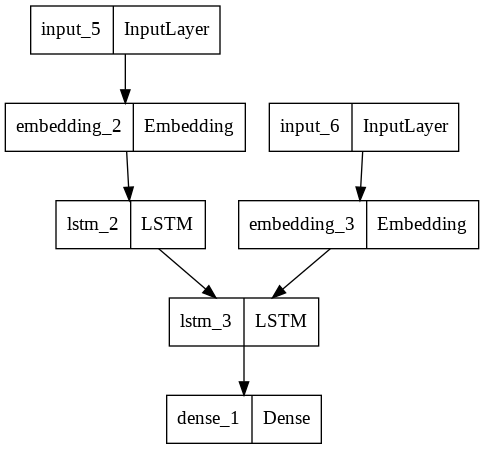

In [ ]:
# первый входной слой

# размеры на входе сетки (здесь будет encoderForInput)
encoderInputs = Input(shape=(None, ))
# Эти данные проходят через слой Embedding (длина словаря, размерность) 
encoderEmbedding = Embedding(vocabularySize, 200 , mask_zero=True) (encoderInputs)

# Затем выход с Embedding пойдёт в LSTM слой, на выходе у которого будет два вектора состояния - state_h , state_c
# Вектора состояния - state_h , state_c зададутся в LSTM слое декодера в блоке ниже
encoderOutputs, state_h , state_c = LSTM(200, return_state=True)(encoderEmbedding)
encoderStates = [state_h, state_c]

# второй входной слой

# размеры на входе сетки (здесь будет decoderForInput)
decoderInputs = Input(shape=(None, ))

# Эти данные проходят через слой Embedding (длина словаря, размерность) 
# mask_zero=True - игнорировать нулевые padding при передаче в LSTM. Предотвратит вывод ответа типа: "У меня все хорошо PAD PAD PAD PAD PAD PAD.."
decoderEmbedding = Embedding(vocabularySize, 200, mask_zero=True) (decoderInputs) 
# Затем выход с Embedding пойдёт в LSTM слой, которому передаются вектора состояния - state_h , state_c
decoderLSTM = LSTM(200, return_state=True, return_sequences=True)
decoderOutputs , _ , _ = decoderLSTM(decoderEmbedding, initial_state=encoderStates)

# И от LSTM'а сигнал decoderOutputs пропускаем через полносвязный слой с софтмаксом на выходе
decoderDense = Dense(vocabularySize, activation='softmax') 
output = decoderDense(decoderOutputs)

# соберем модель переводчика RU_EN
model_RU_EN = Model([encoderInputs, decoderInputs], output)
model_RU_EN.compile(optimizer=RMSprop(), loss='sparse_categorical_crossentropy')

# выведем на экран информацию о построенной модели нейросети
print(model_RU_EN.summary())

# и построим график для визуализации слоев и связей между ними
utils.plot_model(model_RU_EN)

In [ ]:
# обучение модели
model_RU_EN.fit([encoderForInput_RU_EN[:149000], decoderForInput_RU_EN[:149000]], decoderForOutput_RU_EN[:149000], batch_size=256, epochs=50)

Epoch 1/50
583/583 [==============================] - 34s 44ms/step - loss: 2.2352
Epoch 2/50
583/583 [==============================] - 26s 45ms/step - loss: 1.5237
Epoch 3/50
583/583 [==============================] - 26s 45ms/step - loss: 1.2041
Epoch 4/50
583/583 [==============================] - 26s 45ms/step - loss: 0.9919
Epoch 5/50
583/583 [==============================] - 26s 44ms/step - loss: 0.8360
Epoch 6/50
583/583 [==============================] - 26s 44ms/step - loss: 0.7194
Epoch 7/50
583/583 [==============================] - 26s 44ms/step - loss: 0.6320
Epoch 8/50
583/583 [==============================] - 26s 44ms/step - loss: 0.5654
Epoch 9/50
583/583 [==============================] - 26s 44ms/step - loss: 0.5150
Epoch 10/50
583/583 [==============================] - 26s 45ms/step - loss: 0.4768
Epoch 11/50
583/583 [==============================] - 26s 45ms/step - loss: 0.4436
Epoch 12/50
583/583 [==============================] - 26s 45ms/step - loss: 0.4166
E

In [ ]:
# Создадим функцию, которая преобразует вопрос пользователя в последовательность индексов
def strToTokens(sentence):
    # преобразуем вопрос в индексы
    questionToken = tokenizer.texts_to_sequences([sentence])
    maxLenQuestions = max([len(x) for x in questionToken])
    # Вернём входную фразу в виде последовательности индексов
    return pad_sequences(questionToken, maxlen=maxLenQuestions, padding='post')

In [ ]:
# Устанавливаем окончательные настройки и запускаем модель

# запускаем функцию для построения модели кодера и декодера
encModel_RU_EN, decModel_RU_EN = makeInferenceModels()

# задаем количество вопросов
for _ in range(5):

    # Получаем значения состояний, которые определит кодер в соответствии с заданным вопросом
    statesValues_EN_RU = encModel_EN_RU.predict(strToTokens(input('Введите фразу: ')))
    
    # Создаём пустой массив размером (1, 1)
    emptyTargetSeq_EN_RU = np.zeros((1, 1))
    # положим в пустую последовательность начальное слово 'start' в виде индекса
    emptyTargetSeq_EN_RU[0, 0] = tokenizer.word_index['start']
    # зададим условие, при срабатывании которого прекратится генерация очередного слова
    stopCondition_EN_RU = False
    # будем собирать генерируемый ответ
    decodedTranslation_EN_RU = ''

    # запустим цикл, который будет выполняться пока не сработает стоп-условие
    while not stopCondition_EN_RU:
        # В модель декодера подадим пустую последовательность со словом 'start' и состояния предсказанные кодером по заданному вопросу.
        # декодер заменит слово 'start' предсказанным сгенерированным словом и обновит состояния
        decOutputs , h , c = decModel_EN_RU.predict([emptyTargetSeq_EN_RU] + statesValues_EN_RU)

        #получаем индекс предсказанного слова
        sampledWordIndex = np.argmax( decOutputs[0, 0, :])
        # создаем переменную для преобразованных на естественный язык слов
        sampledWord = None

        # циклом переберем все индексы токенайзера
        for word , index in tokenizer.word_index.items():
            # если индекс выбранного слова соответствует какому-то индексу из словаря
            if sampledWordIndex == index:
                # слово, идущее под этим индексом в словаре, добавляется в итоговый ответ
                decodedTranslation_EN_RU += ' {}'.format(word)
                # выбранное слово фиксируем в переменную sampledWord
                sampledWord = word

        # Если выбранным словом оказывается 'end' либо если сгенерированный ответ превышает заданную максимальную длину ответа
        if sampledWord == 'end' or len(decodedTranslation_EN_RU.split()) > maxLenAnswers_EN_RU:
            # то срабатывает стоп-условие и прекращаем генерацию
            stopCondition_EN_RU = True

        
        # заносим в массив индекс выбранного слова
        emptyTargetSeq_EN_RU[0, 0] = sampledWordIndex 
        # и состояния, обновленные декодером
        statesValues_EN_RU = [h, c]
        # и продолжаем цикл с обновленными параметрами
    
    # выводим ответ сгенерированный декодером
    print(f'Перевод: {decodedTranslation_EN_RU[:-4]}')

    # и отправляем эти данные обратному переводчику
    statesValues_RU_EN = encModel_RU_EN.predict(strToTokens(decodedTranslation_EN_RU[:-4]))
    emptyTargetSeq_RU_EN = np.zeros((1, 1))
    emptyTargetSeq_RU_EN[0, 0] = tokenizer.word_index['start']
    stopCondition_RU_EN = False
    decodedTranslation_RU_EN = ''
    
    while not stopCondition_RU_EN:
        decOutputs , h , c = decModel_RU_EN.predict([emptyTargetSeq_RU_EN] + statesValues_RU_EN)
        sampledWordIndex = np.argmax( decOutputs[0, 0, :])
        sampledWord = None

        for word , index in tokenizer.word_index.items():
            if sampledWordIndex == index:
                decodedTranslation_RU_EN += ' {}'.format(word)
                sampledWord = word

        if sampledWord == 'end' or len(decodedTranslation_RU_EN.split()) > maxLenAnswers_RU_EN:
            stopCondition_RU_EN = True

        emptyTargetSeq_RU_EN[0, 0] = sampledWordIndex 
        statesValues_RU_EN = [h, c]
   
    print(f'Перевод перевода: {decodedTranslation_RU_EN[:-4]}')
    print()

Введите фразу: how are you
Перевод:  как твои дела
Перевод перевода:  how are you doing

Введите фразу: they do not remember him
Перевод:  они не помните его как
Перевод перевода:  they don't remember him

Введите фразу: how does he look
Перевод:  как он выглядит
Перевод перевода:  how does he look

Введите фразу: i love winter
Перевод:  я люблю зиму
Перевод перевода:  i like winter

Введите фразу: i don't trust him
Перевод:  я не доверяю ему
Перевод перевода:  i don't trust him

